In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# Append the parent directory to sys.path
sys.path.append(parent_dir)

# Verify that the parent directory was added
print(sys.path[-1])

/home/yuki/quant_project/EURUSD-LSTM-prediction


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_processing import *
import matplotlib.pyplot as plt
import seaborn

# Set the random seed
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_tech = pd.read_csv("../Data/EURUSD_OHLC.csv")
# df_tech["Dates"]=pd.to_datetime(df_tech['Dates'])
# df_tech = df_tech[df_tech["Dates"] > pd.to_datetime("2002-01-01") ] 

df_tech["Last_Return"] =((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_tech["Predict_Return"] = ((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_tech.dropna(inplace=True)
df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return
1,1/3/1980,1.5177,1.5177,1.5177,1.5177,0.001848,-0.003163
2,1/4/1980,1.5129,1.5129,1.5129,1.5129,-0.003163,0.002578
3,1/7/1980,1.5168,1.5168,1.5168,1.5168,0.002578,-0.003956
4,1/8/1980,1.5108,1.5108,1.5108,1.5108,-0.003956,0.003508
5,1/9/1980,1.5161,1.5161,1.5161,1.5161,0.003508,-0.001847
...,...,...,...,...,...,...,...
11466,7/15/2024,1.0903,1.0922,1.0882,1.0894,-0.001192,0.000459
11467,7/16/2024,1.0894,1.0905,1.0872,1.0899,0.000459,0.003670
11468,7/17/2024,1.0899,1.0948,1.0895,1.0939,0.003670,-0.003839
11469,7/18/2024,1.0939,1.0941,1.0894,1.0897,-0.003839,-0.001377


In [3]:
import sys
import os
# sys.path.append("./factors")
# import tech_indicators
from factors import tech_indicators

EURUSD_close = df_tech['PX_LAST'].to_numpy()
EURUSD_typical = ((df_tech['PX_HIGH']+df_tech['PX_LOW']+df_tech['PX_LAST'])/3).to_numpy()

tech_dict =( {"SMA":[[10]],"EMA":[[5,100]],"RSI":[[5],[22],[100]],"MACD":[[26,12],[12,5],[42,18]],"ROC":[[5]],"Bollinger_Bands_lower":[[12],[100]],
             "Bollinger_Bands_upper":[[12],[100]],
              "CCI":[[5],[22],[100]]} )

for key,value in tech_dict.items():
    
    for value in value:
        df_column_name = key
        for para in value:
            df_column_name += ("_"+str(para))
        
        if key[:3] == "CCI":
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_typical,getattr(tech_indicators,key),*value)
            
        else:
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_close,getattr(tech_indicators,key),*value)
        
df_tech.dropna(inplace=True,ignore_index=True)


df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return,SMA_10,EMA_5_100,RSI_5,...,MACD_12_5,MACD_42_18,ROC_5,Bollinger_Bands_lower_12,Bollinger_Bands_lower_100,Bollinger_Bands_upper_12,Bollinger_Bands_upper_100,CCI_5,CCI_22,CCI_100
0,5/27/1980,1.4725,1.4725,1.4725,1.4725,0.008354,-0.003328,1.45190,-691.163309,100.000000,...,0.007195,0.024641,0.021151,1.432406,1.354205,1.468094,1.549607,134.258485,274.066780,34.043608
1,5/28/1980,1.4676,1.4676,1.4676,1.4676,-0.003328,-0.000886,1.45396,-1.090883,56.379822,...,0.007560,0.024186,0.009701,1.434823,1.354549,1.470910,1.548261,59.227299,191.132469,27.108459
2,5/29/1980,1.4663,1.4663,1.4663,1.4663,-0.000886,-0.001159,1.45564,-335.993816,75.000000,...,0.007066,0.024720,0.008529,1.435234,1.354825,1.473583,1.547053,25.847759,154.692263,26.016046
3,5/30/1980,1.4646,1.4646,1.4646,1.4646,-0.001159,-0.001024,1.45715,-752.049206,82.247191,...,0.006509,0.027378,0.002945,1.436500,1.355177,1.475250,1.545657,-36.228721,118.693172,24.332424
4,6/2/1980,1.4631,1.4631,1.4631,1.4631,-0.001024,0.000410,1.45876,292.048549,0.000000,...,0.006710,0.028643,-0.006384,1.437667,1.355439,1.476350,1.544441,-95.728255,93.544744,22.846588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11366,7/15/2024,1.0903,1.0922,1.0882,1.0894,-0.001192,0.000459,1.08319,-87.689132,70.676692,...,0.004461,-0.000664,0.007491,1.069854,1.063786,1.093012,1.095594,84.291188,152.949232,102.425147
11367,7/16/2024,1.0894,1.0905,1.0872,1.0899,0.000459,0.003670,1.08473,-212.509840,67.768595,...,0.004143,-0.000010,0.006371,1.072300,1.063738,1.093667,1.095752,47.488584,126.651530,94.120244
11368,7/17/2024,1.0899,1.0948,1.0895,1.0939,0.003670,-0.003839,1.08626,-238.912644,68.292683,...,0.004955,0.001334,0.006533,1.073873,1.063612,1.095410,1.096080,147.465438,143.407029,126.478733
11369,7/18/2024,1.0939,1.0941,1.0894,1.0897,-0.003839,-0.001377,1.08711,80.280638,45.000000,...,0.003988,0.001838,-0.000917,1.076755,1.063587,1.095062,1.096289,35.127911,112.687632,107.956277


In [4]:
split_point = int(df_tech.shape[0]*0.9)
df_train = df_tech.iloc[:split_point,:]
df_test = df_tech.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

threshold = threshold_search(y_train,1e-6)

print(threshold)



0.002152


In [5]:
y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

In [6]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':5,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.75}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cuda')

net_test.to(device=device,dtype=torch.float64)
loss = nn.CrossEntropyLoss()


def train_epoch(loss_function, optimizer, model, loader,train_data,test_data):
  loss_train = 0
  loss_test = 0
  
  for(i, (x, y)) in enumerate(loader):
    # Clear the gradients
    optimizer.zero_grad()
    
    x=x.to(device=device)
    y=y.to(device=device)
    # Run a forward pass
    outputs = model.forward(x)
    # Compute the batch loss
    loss = loss_function(outputs,y)
    # Calculate the gradients
    loss.backward()
    # Update the parameteres
    optimizer.step()

    
  with torch.no_grad():
    train_outputs = model.forward(train_data[:][0].to(device=device))
    train_loss = loss_function(train_outputs,train_data[:][1].to(device=device))
    loss_train = train_loss.detach().cpu()
    print(f"train loss is {train_loss}")
    
    test_outputs = model.forward(test_data[:][0].to(device=device))
    test_loss = loss_function(test_outputs,test_data[:][1].to(device=device))
    loss_test = test_loss.detach().cpu()
    print(f"test loss is {test_loss}")
        
  return [loss_train, loss_test]   



def train_model(loss_function, optimizer, model, loader,train_data,test_data,epochs=25):
  loss_ls = []
  
  for i in range(epochs):
    print(f"-----------------------Epoch: {i+1}----------------------------------")

    loss_ls.append(train_epoch(loss_function, optimizer, model, loader,train_data,test_data))
    
  return loss_ls

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [7]:
optim_Adam = torch.optim.Adam(net_test.parameters(),lr = 0.0001)
epochs = 100
loss_ls = train_model(loss_function=loss,optimizer=optim_Adam,model=net_test,loader=train_loader,train_data=train_set,
                      test_data=test_set,epochs=epochs)

-----------------------Epoch: 1----------------------------------
train loss is 1.5840478158466569
test loss is 1.5505048287942844
-----------------------Epoch: 2----------------------------------
train loss is 1.4142409414754373
test loss is 1.3873424624331572
-----------------------Epoch: 3----------------------------------
train loss is 1.3181896244826607
test loss is 1.3508522032439445
-----------------------Epoch: 4----------------------------------
train loss is 1.2728650750610189
test loss is 1.2631089331143932
-----------------------Epoch: 5----------------------------------
train loss is 1.2104219142734105
test loss is 1.1995927442113168
-----------------------Epoch: 6----------------------------------
train loss is 1.185533644991895
test loss is 1.1771895808735944
-----------------------Epoch: 7----------------------------------
train loss is 1.1612210422942935
test loss is 1.1291886846880739
-----------------------Epoch: 8----------------------------------
train loss is 1.14

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


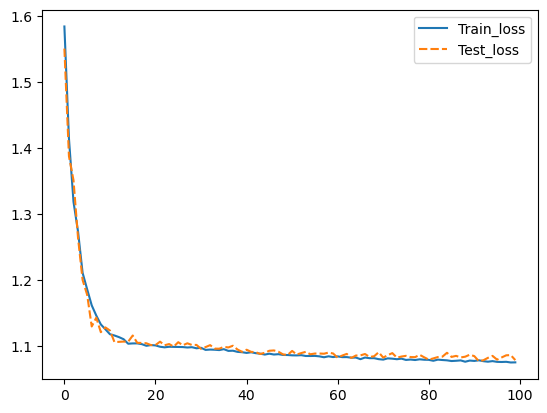

In [8]:
loss_df = pd.DataFrame(data=np.array(loss_ls),columns=["Train_loss", "Test_loss"])
seaborn.lineplot(data=loss_df)
plt.show()

In [9]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))
net_test.eval()

predict_probability = torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0]

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]

accuracy_score(real_results,predict_results)

0.41718889883616833

In [10]:
act_predict_bool = (predict_results != 1) & (predict_probability > 0.35)

act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]

accuracy_score(act_predict_results,act_real_results)

0.34934497816593885

In [11]:
act_predict_results.shape

torch.Size([229])

In [12]:
saved_path = "../trained_model/Tec_LSTM.pth"

torch.save(net_test.state_dict(),saved_path )